# **Question No.1. Vision Dataset**
A python notebook to build, train and evaluate a deep neural network on the CIFAR-10 dataset(60000 32x32 colour images in 10 classes).

### 1. Import Libraries/Dataset

##### a. importing required libraries

In [1]:
#importing required libraries
import tensorflow as tf
print(tf.__version__)

import random
import numpy as np
import pandas as pd
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from keras.optimizers import SGD
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint 
from sklearn import metrics  
import time

import keras
from keras.datasets import cifar10

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools
import helper
%matplotlib inline

2.3.0


In [2]:
random.seed(42)         # Initialize the random number generator.
np.random.seed(42)      # With the seed reset, the same set of 
                        # numbers will appear every time. 
tf.random.set_seed(42)  # sets the graph-level random seed

b. Import the dataset

In [3]:
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

##### c. Check the GPU available

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7886451131236722138
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2412301110308031309
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13151779825816841031
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11146783616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7634041584454326895
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


### 2. Data Visualization

###### a. Plot sample from each class of the dataset

In [6]:
class_names = np.unique(y_train)
class_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Example training images and their labels: [6, 9, 9, 4, 1, 1, 2, 7, 8]
Corresponding classes for the labels: ['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship']


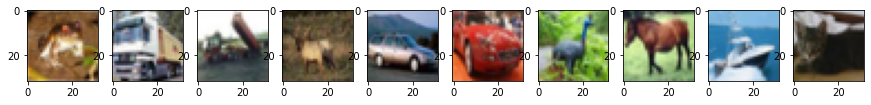

In [7]:
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Example training images and their labels: ' + str([x[0] for x in y_train[0:9]])) 
print('Corresponding classes for the labels: ' + str([cifar_classes[x[0]] for x in y_train[0:9]]))
f, axarr = plt.subplots(1,10)
f.set_size_inches(15, 8)

for i in range(10):
    img = X_train[i]
    axarr[i].imshow(img)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The 'shape' parameter of imshow() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'shape', they should be pass as keyword, not positionally.
  This is separate from the ipykernel package so we can avoid doing imports until


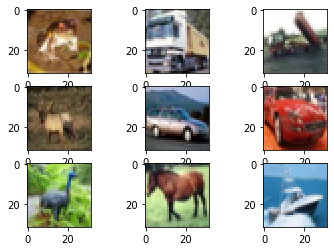

In [8]:
for i in range(0,9):
  plt.subplot(330+1+i)
  plt.imshow(X_train[i],interpolation='nearest',shape=(50,50))
#Show the plot
plt.show()

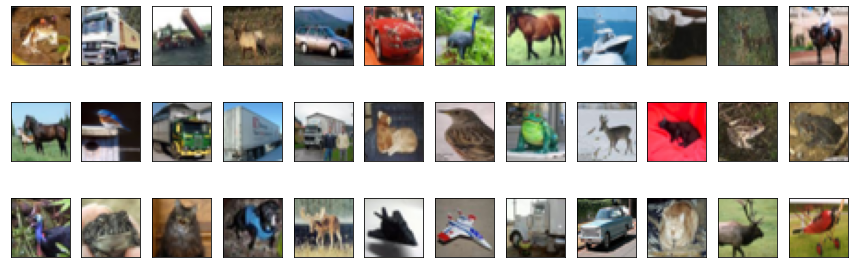

In [9]:
#Exploring some images!
%matplotlib inline
def plot_images(X_train):
    fig = plt.figure(figsize=(15,5))
    for i in range(36):
        ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_train[i]))
plot_images(X_train)

##### Print the shapes of train and test data

In [10]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)  

X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


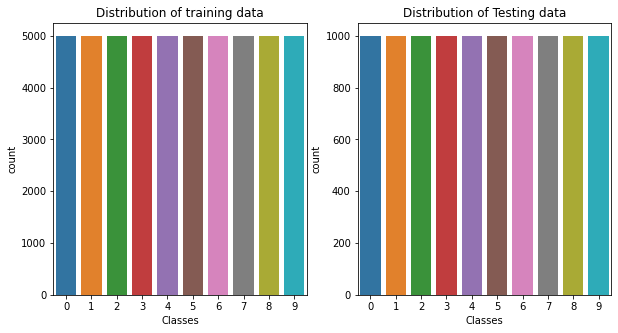

In [11]:
fig, axs = plt.subplots(1,2,figsize=(10,5)) 
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

### 3. Data Pre-processing

###### a. Bringing the train and test data in the required format

In [12]:
# Normalize the data
# 50000 input images are in the train set.
# 10000 input images are in the test set.
# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)

X_train = X_train.reshape((50000, 32*32*3))    # reshape the input set to size 32*32*3. Vcctor of length 3072
X_train = X_train.astype('float32')/255      # normalize to grayscale; set datatype as float32

X_test = X_test.reshape((10000, 32*32*3))      # reshape the input set to size 32*32*3. 
X_test = X_test.astype('float32')/255        # normalize to grayscale; set datatype as float32

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [13]:
# print a sample data

print('X_train \n', X_train[10,10])
print('X_test \n', X_test[10,10])
print('y_train \n', y_train[10,])
print('y_test \n', y_test[10,])

X_train 
 0.23137255
X_test 
 0.49019608
y_train 
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
y_test 
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
# break training set into training and validation sets
(X_train, X_valid) = X_train[5000:], X_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

### 4. Model Building - DNN MODEL

##### a. Sequential Model layers- Using AT LEAST 3 dense layers with appropriate input for each. 
* Using Keras, create the DNN or Sequential Model

In [15]:
# Create a model object
dnnModel = models.Sequential()

* Add dense layers, specifying the number of units in each layer and the activation function used in the layer.
* choosing more no of hidden units increases the total params count.
* Linear activation functions like ReLU, sigmoid and softmax used for multiclass classification.
* Dropout a regularizer technique that reduces the odds of overfitting by dropping out neurons at random, during every epoch. 
* Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

In [16]:
#a. Add dense layers, specifying the number of units in each layer and the activation function used in the layer.
#b. Add L2 regularization to all the layers.
#c. Add one layer of dropout at the appropriate position and give reasons.

# Layer 1 = input layer
# specify the input size in the first layer.
dnnModel.add(Flatten(input_shape = X_train.shape[1:]))
dnnModel.add(layers.Dense(1024, activation='relu', input_shape= (32*32*3,)))
# Layer 2 = hidden layer 
dnnModel.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

# Add dropout of 30% to layer 3
dnnModel.add(layers.Dropout(0.3))

# Layer 3 = hidden layer 
dnnModel.add(layers.Dense(256, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

# Layer 4 = hidden layer 
dnnModel.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005)))


# Layer 5 = output layer
dnnModel.add(layers.Dense(10, activation='softmax') )

dnnModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1

### 5. Model Compilation

In [17]:
# Configure  the model for training, by using appropriate optimizers and regularizations
# Available optimizer: adam, rmsprop, adagrad, sgd
# loss: objective that the model will try to minimize. 
# Available loss: categorical_crossentropy, binary_crossentropy, mean_ssquared_error
# metrics: List of metrics to be evaluated by the model during training and testing. 

# Let's check accuracy with hypertuning for adam and large batch size = 512.
opt = keras.optimizers.Adam(learning_rate=0.0001)
dnnModel.compile( optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy'] )

### 6. MODEL TRAINING

* larger the batch size, faster is the training time.

In [18]:
# train the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mlp_start = time.time()
checkpointer = ModelCheckpoint(filepath='dnnModel.best.hdf5', 
                               verbose=1, save_best_only=True)
h = dnnModel.fit(X_train, y_train, epochs=25, batch_size=256, validation_split=0.2, callbacks=[checkpointer],verbose=2, shuffle=True)
mlp_end = time.time()
mlp_took = mlp_end -mlp_start
print("Total time taken: %s seconds"%(mlp_took))

Epoch 1/25

Epoch 00001: val_loss improved from inf to 2.71604, saving model to dnnModel.best.hdf5
141/141 - 2s - loss: 3.0225 - accuracy: 0.2570 - val_loss: 2.7160 - val_accuracy: 0.3270
Epoch 2/25

Epoch 00002: val_loss improved from 2.71604 to 2.44075, saving model to dnnModel.best.hdf5
141/141 - 2s - loss: 2.5719 - accuracy: 0.3481 - val_loss: 2.4408 - val_accuracy: 0.3654
Epoch 3/25

Epoch 00003: val_loss improved from 2.44075 to 2.27682, saving model to dnnModel.best.hdf5
141/141 - 2s - loss: 2.3508 - accuracy: 0.3795 - val_loss: 2.2768 - val_accuracy: 0.3859
Epoch 4/25

Epoch 00004: val_loss improved from 2.27682 to 2.17754, saving model to dnnModel.best.hdf5
141/141 - 2s - loss: 2.2138 - accuracy: 0.4013 - val_loss: 2.1775 - val_accuracy: 0.3942
Epoch 5/25

Epoch 00005: val_loss improved from 2.17754 to 2.09825, saving model to dnnModel.best.hdf5
141/141 - 2s - loss: 2.1213 - accuracy: 0.4162 - val_loss: 2.0982 - val_accuracy: 0.4221
Epoch 6/25

Epoch 00006: val_loss improved f

### 7. Model Evaluation

In [19]:
# load the weights that yielded the best validation accuracy
dnnModel.load_weights('dnnModel.best.hdf5')

# evaluate test accuracy
score = dnnModel.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 52.2100%


In [20]:
print('Final training loss \t', h.history['loss'][-1])
print('Final training accuracy ', h.history['accuracy'][-1])

Final training loss 	 1.4632302522659302
Final training accuracy  0.5677222013473511


In [21]:
def plotLosses(h): 
  plt.plot(h.history['accuracy'], label='train')
  plt.plot(h.history['val_accuracy'], label='validation')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Plot of Accuracy')
  plt.legend()
  plt.show()

  plt.plot(h.history['loss'], label='train')
  plt.plot(h.history['val_loss'], label='validation')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Plot of Loss')
  plt.legend()
  plt.show()

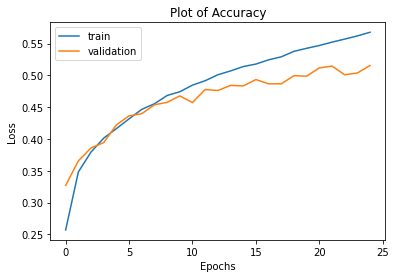

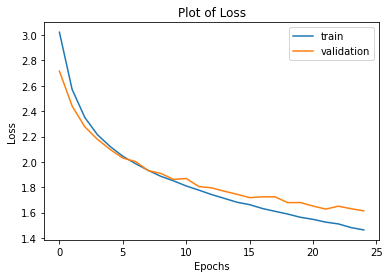

In [22]:
plotLosses(h)

In [23]:
score = dnnModel.evaluate(X_test, y_test, batch_size=128, verbose=0)
print(dnnModel.metrics_names)
print(score)

['loss', 'accuracy']
[1.5993906259536743, 0.5220999717712402]


In [24]:
from sklearn.metrics import confusion_matrix
rounded_predictions = dnnModel.predict_classes(X_test, batch_size=64, verbose=0)
rounded_labels=np.argmax(y_test, axis=1)
cm = confusion_matrix(rounded_labels, rounded_predictions)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [25]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

-----------------CIFAR-10 DNN Model Report---------------
F1 score: 0.5141323367212085
Accuracy score: 0.5221
Confusion matrix: 
 [[607  43  35  27  29   8  37  24  82 108]
 [ 24 691   9  18   9   4  20  15  31 179]
 [ 95  29 287 129 116  50 173  75  11  35]
 [ 33  28  54 422  44 103 168  59  18  71]
 [ 65  22  82  86 396  18 186  98  15  32]
 [ 34  16  59 306  54 277 106  90  22  36]
 [  8  12  25  91  72  19 715  21  10  27]
 [ 37  24  30  88  55  37  36 585   8 100]
 [130  90   6  38  13   6  18   7 575 117]
 [ 25 178   5  41   5   5  23  28  24 666]]

----------------------
Plotting confusion matrix -->

Confusion matrix, without normalization


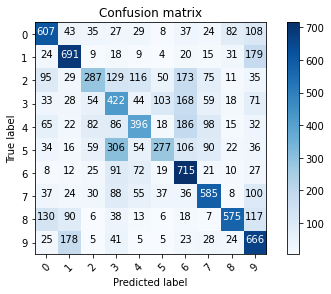

              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1000
           1       0.61      0.69      0.65      1000
           2       0.48      0.29      0.36      1000
           3       0.34      0.42      0.38      1000
           4       0.50      0.40      0.44      1000
           5       0.53      0.28      0.36      1000
           6       0.48      0.71      0.58      1000
           7       0.58      0.58      0.58      1000
           8       0.72      0.57      0.64      1000
           9       0.49      0.67      0.56      1000

    accuracy                           0.52     10000
   macro avg       0.53      0.52      0.51     10000
weighted avg       0.53      0.52      0.51     10000



In [26]:
dnn_f1 = metrics.f1_score(rounded_labels, rounded_predictions, average= "weighted")
dnn_acc = metrics.accuracy_score(rounded_labels, rounded_predictions)
dnn_cm = metrics.confusion_matrix(rounded_labels, rounded_predictions)

print("-----------------CIFAR-10 DNN Model Report---------------")
print("F1 score: {}".format(dnn_f1))
print("Accuracy score: {}".format(dnn_acc))
print("Confusion matrix: \n", dnn_cm)
print("\n----------------------")
print('Plotting confusion matrix -->\n')

plt.figure()
plot_confusion_matrix(dnn_cm, class_names)
plt.show()

print(metrics.classification_report(rounded_labels, rounded_predictions))

### Hyperparameter tuning
1. Optimiser: Using SGD as a different optimizer with the appropriate LR value = 0.01

In [27]:
#regularization and optimization using SGD wit learning rate 0.01 gives better accuracy .
sgd = SGD(lr=0.01)
dnnModel.compile( optimizer = 'sgd', loss = 'categorical_crossentropy', metrics=['accuracy'] )

In [28]:
# train the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mlp_start = time.time()
checkpointer = ModelCheckpoint(filepath='dnnModel.best.hdf5', 
                               verbose=1, save_best_only=True)
h = dnnModel.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.2, callbacks=[checkpointer],verbose=2, shuffle=True)
mlp_end = time.time()
mlp_took = mlp_end -mlp_start
print("Total time taken: %s seconds"%(mlp_took))

Epoch 1/25

Epoch 00001: val_loss improved from inf to 1.60940, saving model to dnnModel.best.hdf5
563/563 - 3s - loss: 1.4362 - accuracy: 0.5766 - val_loss: 1.6094 - val_accuracy: 0.5132
Epoch 2/25

Epoch 00002: val_loss did not improve from 1.60940
563/563 - 3s - loss: 1.4237 - accuracy: 0.5806 - val_loss: 1.6513 - val_accuracy: 0.5001
Epoch 3/25

Epoch 00003: val_loss did not improve from 1.60940
563/563 - 3s - loss: 1.4126 - accuracy: 0.5837 - val_loss: 1.6629 - val_accuracy: 0.5053
Epoch 4/25

Epoch 00004: val_loss did not improve from 1.60940
563/563 - 3s - loss: 1.3971 - accuracy: 0.5895 - val_loss: 1.6138 - val_accuracy: 0.5131
Epoch 5/25

Epoch 00005: val_loss did not improve from 1.60940
563/563 - 3s - loss: 1.3878 - accuracy: 0.5897 - val_loss: 1.6684 - val_accuracy: 0.4937
Epoch 6/25

Epoch 00006: val_loss did not improve from 1.60940
563/563 - 3s - loss: 1.3779 - accuracy: 0.5947 - val_loss: 1.7310 - val_accuracy: 0.4767
Epoch 7/25

Epoch 00007: val_loss improved from 1.60

In [29]:
print('Final training loss \t', h.history['loss'][-1])
print('Final training accuracy ', h.history['accuracy'][-1])

Final training loss 	 1.2029492855072021
Final training accuracy  0.640250027179718


In [30]:
# load the weights that yielded the best validation accuracy
dnnModel.load_weights('dnnModel.best.hdf5')
# evaluate test accuracy
score = dnnModel.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]
# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 53.6600%


In [ ]:
from sklearn.metrics import confusion_matrix
rounded_predictions = dnnModel.predict_classes(X_test, batch_size=64, verbose=0)
rounded_labels=np.argmax(y_test, axis=1)
cm = confusion_matrix(rounded_labels, rounded_predictions)

-----------------CIFAR-10 DNN Model Report---------------
F1 score: 0.5141323367212085
Accuracy score: 0.5221
Confusion matrix: 
 [[607  43  35  27  29   8  37  24  82 108]
 [ 24 691   9  18   9   4  20  15  31 179]
 [ 95  29 287 129 116  50 173  75  11  35]
 [ 33  28  54 422  44 103 168  59  18  71]
 [ 65  22  82  86 396  18 186  98  15  32]
 [ 34  16  59 306  54 277 106  90  22  36]
 [  8  12  25  91  72  19 715  21  10  27]
 [ 37  24  30  88  55  37  36 585   8 100]
 [130  90   6  38  13   6  18   7 575 117]
 [ 25 178   5  41   5   5  23  28  24 666]]

----------------------
Plotting confusion matrix -->

Confusion matrix, without normalization


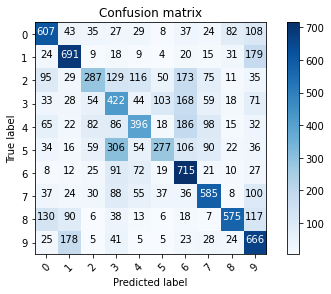

              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1000
           1       0.61      0.69      0.65      1000
           2       0.48      0.29      0.36      1000
           3       0.34      0.42      0.38      1000
           4       0.50      0.40      0.44      1000
           5       0.53      0.28      0.36      1000
           6       0.48      0.71      0.58      1000
           7       0.58      0.58      0.58      1000
           8       0.72      0.57      0.64      1000
           9       0.49      0.67      0.56      1000

    accuracy                           0.52     10000
   macro avg       0.53      0.52      0.51     10000
weighted avg       0.53      0.52      0.51     10000



In [31]:
dnn_f1 = metrics.f1_score(rounded_labels, rounded_predictions, average= "weighted")
dnn_acc = metrics.accuracy_score(rounded_labels, rounded_predictions)
dnn_cm = metrics.confusion_matrix(rounded_labels, rounded_predictions)

print("-----------------CIFAR-10 DNN Model Report---------------")
print("F1 score: {}".format(dnn_f1))
print("Accuracy score: {}".format(dnn_acc))
print("Confusion matrix: \n", dnn_cm)
print("\n----------------------")
print('Plotting confusion matrix -->\n')

plt.figure()
plot_confusion_matrix(dnn_cm, class_names)
plt.show()

print(metrics.classification_report(rounded_labels, rounded_predictions))

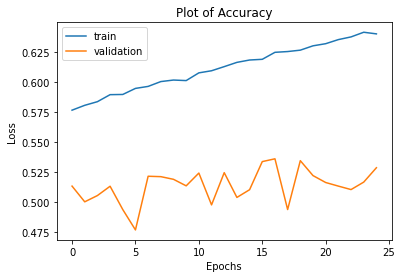

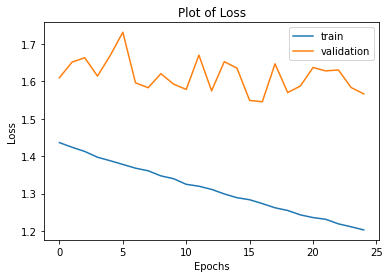

In [32]:
plotLosses(h)

#### Hypertuning using RMSprop optimizer with LR=0.001

In [33]:
#regularization using optimizer rmsprop
opt = tf.keras.optimizers.RMSprop(lr=0.001)
dnnModel.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# train the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mlp_start = time.time()
checkpointer = ModelCheckpoint(filepath='dnnModel.best.hdf5', 
                               verbose=1, save_best_only=True)
h = dnnModel.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.2, callbacks=[checkpointer],verbose=2, shuffle=True)
mlp_end = time.time()
mlp_took = mlp_end -mlp_start
print("Total time taken: %s seconds"%(mlp_took))

Epoch 1/25

Epoch 00001: val_loss improved from inf to 1.84865, saving model to dnnModel.best.hdf5
563/563 - 4s - loss: 2.1983 - accuracy: 0.2482 - val_loss: 1.8486 - val_accuracy: 0.3536
Epoch 2/25

Epoch 00002: val_loss did not improve from 1.84865
563/563 - 4s - loss: 1.8201 - accuracy: 0.3632 - val_loss: 2.1137 - val_accuracy: 0.2804
Epoch 3/25

Epoch 00003: val_loss improved from 1.84865 to 1.84502, saving model to dnnModel.best.hdf5
563/563 - 4s - loss: 1.7356 - accuracy: 0.4015 - val_loss: 1.8450 - val_accuracy: 0.3531
Epoch 4/25

Epoch 00004: val_loss did not improve from 1.84502
563/563 - 4s - loss: 1.6758 - accuracy: 0.4202 - val_loss: 1.8528 - val_accuracy: 0.3693
Epoch 5/25

Epoch 00005: val_loss improved from 1.84502 to 1.74595, saving model to dnnModel.best.hdf5
563/563 - 4s - loss: 1.6335 - accuracy: 0.4421 - val_loss: 1.7459 - val_accuracy: 0.3827
Epoch 6/25

Epoch 00006: val_loss did not improve from 1.74595
563/563 - 4s - loss: 1.5999 - accuracy: 0.4543 - val_loss: 1.

In [35]:
print('Final training loss \t', h.history['loss'][-1])
print('Final training accuracy ', h.history['accuracy'][-1])

Final training loss 	 1.3133724927902222
Final training accuracy  0.5689444541931152


In [36]:
dnnModel.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.5552 - accuracy: 0.4912


[1.5551718473434448, 0.4912000000476837]

In [37]:
# load the weights that yielded the best validation accuracy
dnnModel.load_weights('dnnModel.best.hdf5')
# evaluate test accuracy
score = dnnModel.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]
# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 51.7200%


In [54]:
from sklearn.metrics import confusion_matrix
rounded_predictions = dnnModel.predict_classes(X_test, batch_size=64, verbose=0)
rounded_labels=np.argmax(y_test, axis=1)
cm = confusion_matrix(rounded_labels, rounded_predictions)

-----------------CIFAR-10 DNN Model Report---------------
F1 score: 0.5341554341910337
Accuracy score: 0.5366
Confusion matrix: 
 [[583  35  59  30  42  15  30  20 147  39]
 [ 35 701  10  28   7  11  16  19  66 107]
 [ 72  14 382 116 159  62 117  44  17  17]
 [ 24  24  84 406  56 155 135  47  26  43]
 [ 50  19 133  66 448  37 136  68  32  11]
 [ 22  10  84 282  73 360  76  51  23  19]
 [  4  14  54  69 103  48 667  12  13  16]
 [ 37  11  45  79  92  72  25 577  18  44]
 [ 87  80  12  21  18  15  13  10 702  42]
 [ 41 220  13  45   9  15  17  38  62 540]]

----------------------
Plotting confusion matrix -->

Confusion matrix, without normalization


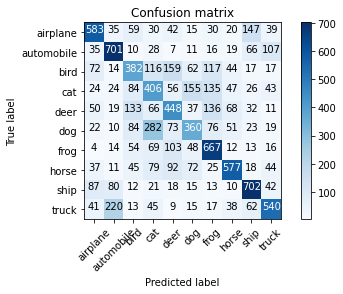

              precision    recall  f1-score   support

           0       0.61      0.58      0.60      1000
           1       0.62      0.70      0.66      1000
           2       0.44      0.38      0.41      1000
           3       0.36      0.41      0.38      1000
           4       0.44      0.45      0.45      1000
           5       0.46      0.36      0.40      1000
           6       0.54      0.67      0.60      1000
           7       0.65      0.58      0.61      1000
           8       0.63      0.70      0.67      1000
           9       0.62      0.54      0.58      1000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.53     10000
weighted avg       0.54      0.54      0.53     10000



In [55]:
dnn_f1 = metrics.f1_score(rounded_labels, rounded_predictions, average= "weighted")
dnn_acc = metrics.accuracy_score(rounded_labels, rounded_predictions)
dnn_cm = metrics.confusion_matrix(rounded_labels, rounded_predictions)

print("-----------------CIFAR-10 DNN Model Report---------------")
print("F1 score: {}".format(dnn_f1))
print("Accuracy score: {}".format(dnn_acc))
print("Confusion matrix: \n", dnn_cm)
print("\n----------------------")
print('Plotting confusion matrix -->\n')

plt.figure()
plot_confusion_matrix(dnn_cm, class_names)
plt.show()

print(metrics.classification_report(rounded_labels, rounded_predictions))

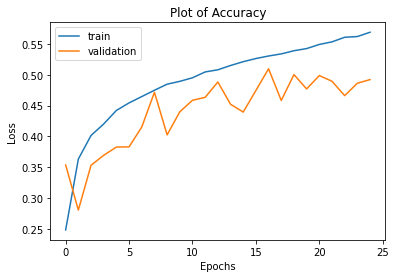

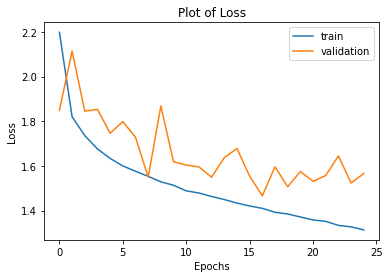

In [39]:
plotLosses(h)

### Hyperparameter tuning 
2. Batch Size: Changed the value of batch size in model training for adam from 256 to 64.
* adam with lesser training rate as 0.0001 and small batch gives better accuracy than higher leanring rate,also loss seems to be converging at this point(approx 1)

In [40]:
#Regularisation & optimizing DNN using optimizer Adam and different batch size = 32

opt = keras.optimizers.Adam(learning_rate=0.0001)
dnnModel.compile( optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy'] )

In [41]:
# train the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mlp_start = time.time()
checkpointer = ModelCheckpoint(filepath='dnnModel.best.hdf5', 
                               verbose=1, save_best_only=True)
h = dnnModel.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.2, callbacks=[checkpointer],verbose=2, shuffle=True)
mlp_end = time.time()
mlp_took = mlp_end -mlp_start
print("Total time taken: %s seconds"%(mlp_took))

Epoch 1/25

Epoch 00001: val_loss improved from inf to 1.41847, saving model to dnnModel.best.hdf5
563/563 - 4s - loss: 1.2374 - accuracy: 0.5901 - val_loss: 1.4185 - val_accuracy: 0.5300
Epoch 2/25

Epoch 00002: val_loss did not improve from 1.41847
563/563 - 4s - loss: 1.2068 - accuracy: 0.6033 - val_loss: 1.4223 - val_accuracy: 0.5301
Epoch 3/25

Epoch 00003: val_loss improved from 1.41847 to 1.41025, saving model to dnnModel.best.hdf5
563/563 - 4s - loss: 1.1936 - accuracy: 0.6070 - val_loss: 1.4103 - val_accuracy: 0.5368
Epoch 4/25

Epoch 00004: val_loss did not improve from 1.41025
563/563 - 4s - loss: 1.1805 - accuracy: 0.6105 - val_loss: 1.4118 - val_accuracy: 0.5368
Epoch 5/25

Epoch 00005: val_loss improved from 1.41025 to 1.40836, saving model to dnnModel.best.hdf5
563/563 - 4s - loss: 1.1721 - accuracy: 0.6132 - val_loss: 1.4084 - val_accuracy: 0.5370
Epoch 6/25

Epoch 00006: val_loss did not improve from 1.40836
563/563 - 4s - loss: 1.1617 - accuracy: 0.6171 - val_loss: 1.

In [42]:
print('Final training loss \t', h.history['loss'][-1])
print('Final training accuracy ', h.history['accuracy'][-1])

Final training loss 	 1.0210250616073608
Final training accuracy  0.6681944727897644


In [43]:
# load the weights that yielded the best validation accuracy
dnnModel.load_weights('dnnModel.best.hdf5')
# evaluate test accuracy
score = dnnModel.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]
# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 53.6600%


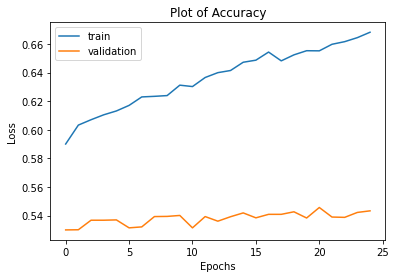

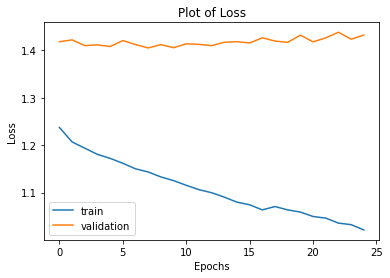

In [44]:
plotLosses(h)

In [45]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [46]:
d = {}
i=0

for c in class_names:
    d[i] = c
    i+=1
d

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [47]:
predictions=dnnModel.predict_classes(X_test)
ans = pd.Series(predictions).replace(d)
ans

0            cat
1           ship
2       airplane
3       airplane
4           deer
          ...   
9995         dog
9996         dog
9997         cat
9998        deer
9999       horse
Length: 10000, dtype: object

In [52]:
from sklearn.metrics import confusion_matrix
rounded_predictions = dnnModel.predict_classes(X_test, batch_size=64, verbose=0)
rounded_labels=np.argmax(y_test, axis=1)
cm = confusion_matrix(rounded_labels, rounded_predictions)

-----------------CIFAR-10 DNN Model Report---------------
F1 score: 0.5341554341910337
Accuracy score: 0.5366
Confusion matrix: 
 [[583  35  59  30  42  15  30  20 147  39]
 [ 35 701  10  28   7  11  16  19  66 107]
 [ 72  14 382 116 159  62 117  44  17  17]
 [ 24  24  84 406  56 155 135  47  26  43]
 [ 50  19 133  66 448  37 136  68  32  11]
 [ 22  10  84 282  73 360  76  51  23  19]
 [  4  14  54  69 103  48 667  12  13  16]
 [ 37  11  45  79  92  72  25 577  18  44]
 [ 87  80  12  21  18  15  13  10 702  42]
 [ 41 220  13  45   9  15  17  38  62 540]]

----------------------
Plotting confusion matrix -->

Confusion matrix, without normalization


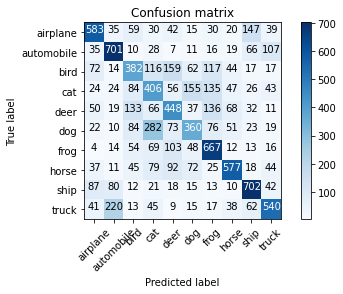

              precision    recall  f1-score   support

           0       0.61      0.58      0.60      1000
           1       0.62      0.70      0.66      1000
           2       0.44      0.38      0.41      1000
           3       0.36      0.41      0.38      1000
           4       0.44      0.45      0.45      1000
           5       0.46      0.36      0.40      1000
           6       0.54      0.67      0.60      1000
           7       0.65      0.58      0.61      1000
           8       0.63      0.70      0.67      1000
           9       0.62      0.54      0.58      1000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.53     10000
weighted avg       0.54      0.54      0.53     10000



In [53]:
dnn_f1 = metrics.f1_score(rounded_labels, rounded_predictions, average= "weighted")
dnn_acc = metrics.accuracy_score(rounded_labels, rounded_predictions)
dnn_cm = metrics.confusion_matrix(rounded_labels, rounded_predictions)

print("-----------------CIFAR-10 DNN Model Report---------------")
print("F1 score: {}".format(dnn_f1))
print("Accuracy score: {}".format(dnn_acc))
print("Confusion matrix: \n", dnn_cm)
print("\n----------------------")
print('Plotting confusion matrix -->\n')

plt.figure()
plot_confusion_matrix(dnn_cm, class_names)
plt.show()

print(metrics.classification_report(rounded_labels, rounded_predictions))

### Observations :

* Three optimizers were used, namely Adam, SGD and RMSprop optimizers, and two learning rates were used for SGD =0.01 and adam=0.0001.For a learning rate of adam with 0.001, the difference was mild. 
* For consistency of results and due to the size of the dataset, the number of epochs was fixed to 25 epochs.
* Larger batch size quickens the computation of the network but decreases the updates required for the network to reach convergence.
* Larger the batch size, the higher the performance and computation is faster.
* To overcome overfitting, only the best model was saved, meaning that during the training phase, if the validation accuracy of the epoch was higher than the highest accuracy, then the model was saved.
* A small batch size converge faster than a large batch. Also, a small batch size have a significant regularization effect which requires a small learning rate to prevent it from overshooting the minima.
* Small batch sizes require small learning rates and computation takes longer.
* Algorithms when hypertuned performs better than with the default values.

### Summary :

* Most widely used and practical optimizers for training deep learning models is Adam.
* Adam learns the fastest. Adam is more stable than the other optimizers, it doesn’t suffer any major decreases in accuracy. 
* SGD only computes on a small subset or random selection of data examples. SGD produces the same performance as regular gradient descent when the learning rate is low.
* Convolutional neural networks have shown superior accuracy in image classification, but to accurately train a DNN uisng only dense layers, many hyperparameters need to be tuned depending on the dataset being used.
* With respect to the given CIFAR-10 data set and dense MLP neural network models trained in the given notebook, we can infer that Adam is a better optimizer. SGD performs better next to Adam. RMSprop has varying metrics in learning the model.
* Overall there is huge difference in accuracy observed for the model using different optimizers.
* Adam slightly outperform RMSprop towards the end of optimization as gradients become sparser. Insofar, Adam might be the best overall choice.
* Using only dense layers for a MLP , better accuracy of approx 55% obtained with optimiser as Adam and lower learning rate 0.0001.
